In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

# Modelling imports
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.vector_ar import VAR

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout


import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR

Using TensorFlow backend.


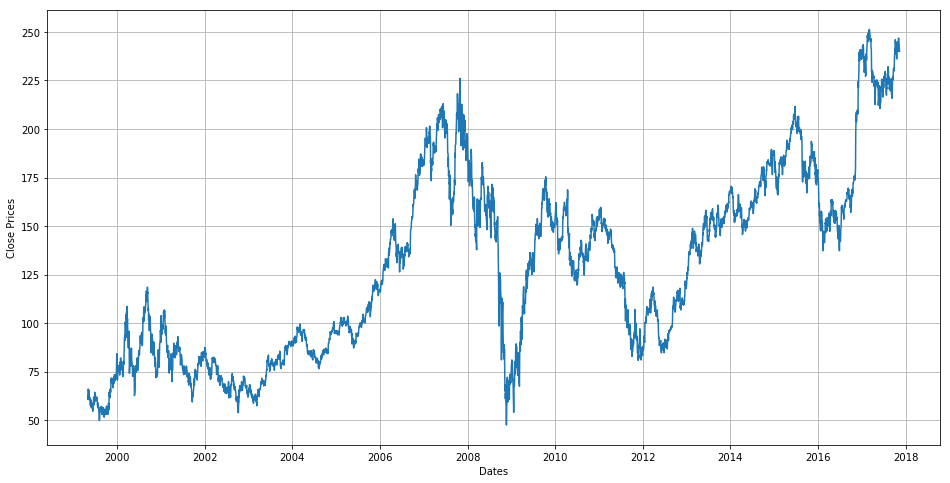

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('dataset.txt', sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close']);


# Data Analysis

No handles with labels found to put in legend.


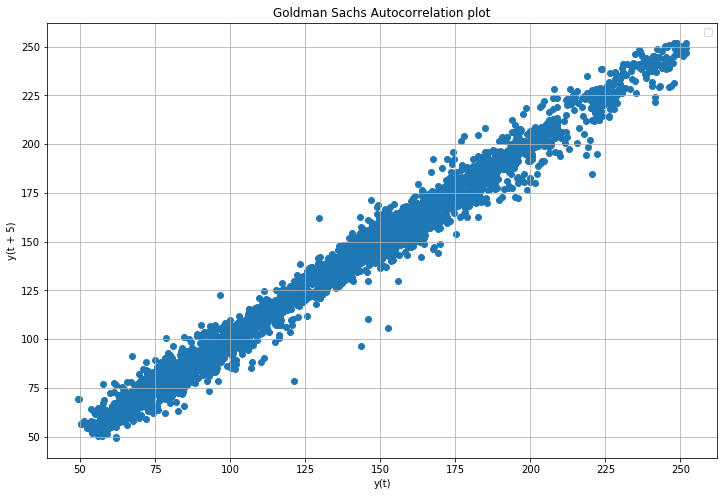

In [3]:
plt.figure(figsize=(12,8))
lag_plot(data['Open'], lag=5)
plt.title('Goldman Sachs Autocorrelation plot')
plt.grid(True)
plt.legend();

<Figure size 1152x576 with 0 Axes>

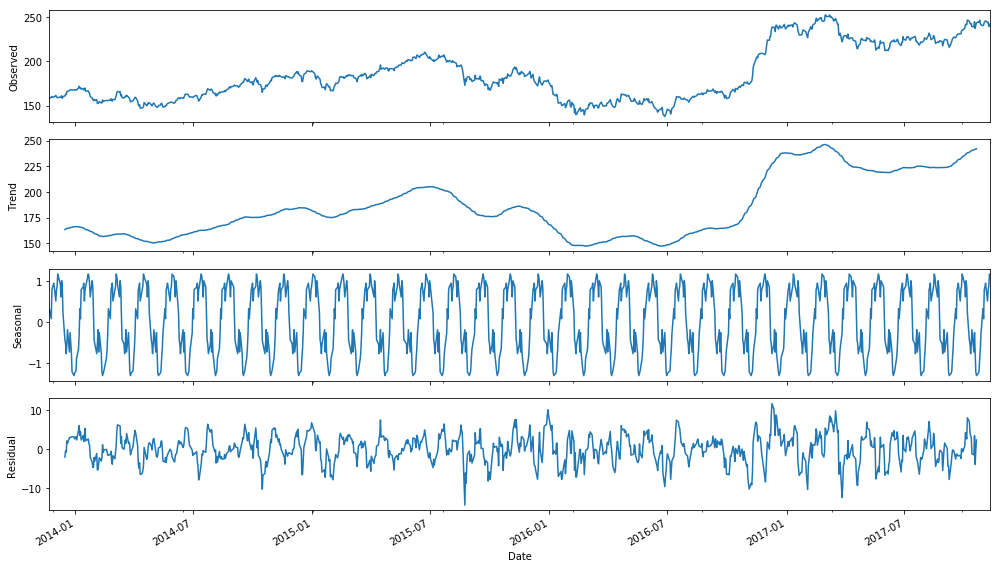

In [4]:
rcParams['figure.figsize'] = 14, 8
data_arima = data['Open']
result = seasonal_decompose(data_arima[-1000:], model='additive', freq=30)
plt.figure(figsize=(16,8))
fig = result.plot()
plt.show()

In [5]:
values = DataFrame(data['Open'].values)
dataframe = concat([values.shift(1),values.shift(5),values.shift(10),values.shift(30), values], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)

             t       t+1       t+5      t+10      t+30
t     1.000000  0.994216  0.988282  0.956678  0.998288
t+1   0.994216  1.000000  0.992890  0.963463  0.992929
t+5   0.988282  0.992890  1.000000  0.971829  0.987001
t+10  0.956678  0.963463  0.971829  1.000000  0.954921
t+30  0.998288  0.992929  0.987001  0.954921  1.000000


# Train Test Split

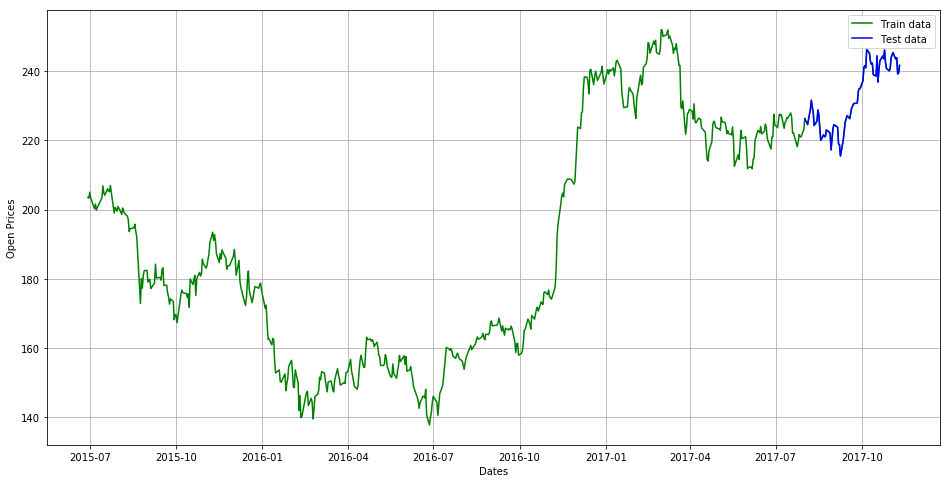

In [6]:
train_data, test_data = data[0:-73], data[-73:]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'].tail(600), 'green', label='Train data')
plt.plot(test_data['Open'], 'blue', label='Test data')
plt.legend()

# Mean value plot

MSE: 10830.046294143665
MAE: 103.67446296726261
RMSE: 104.0675083498383


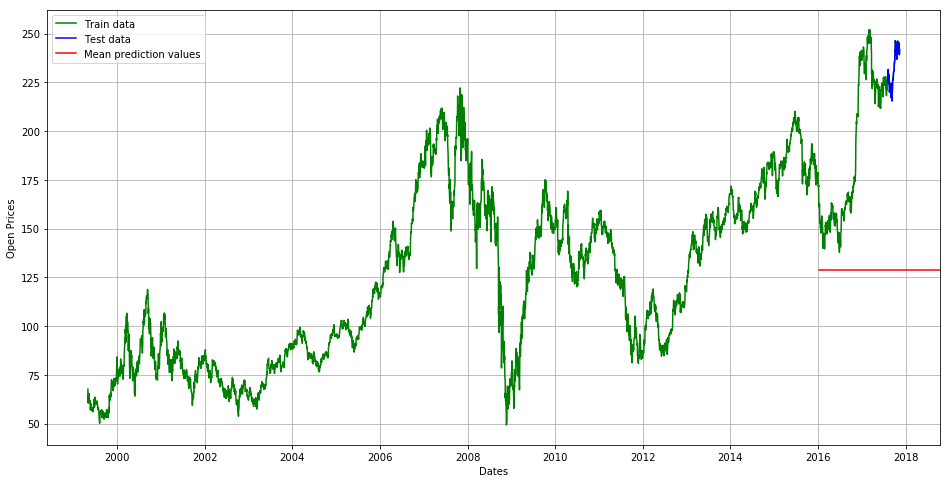

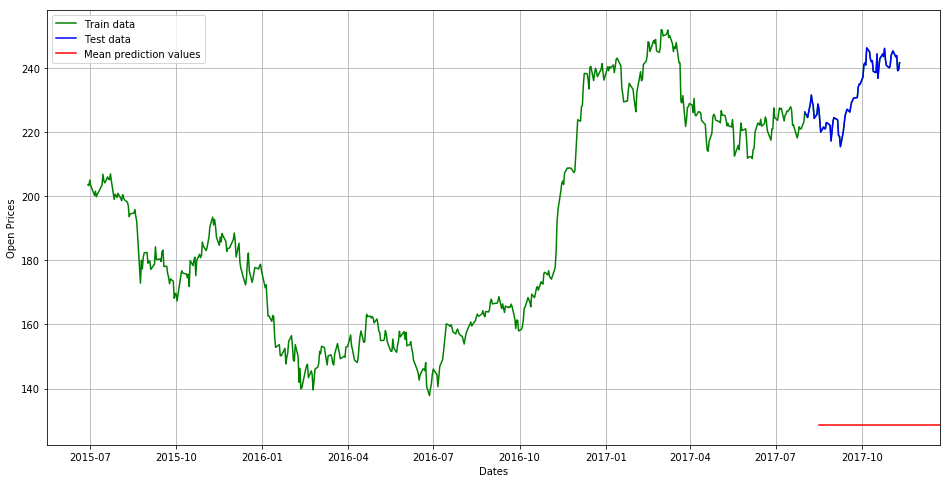

In [7]:
mean_value = data['Open'].mean() # calculation of mean price

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'], 'green', label='Train data')
plt.plot(test_data['Open'], 'blue', label='Test data')
plt.axhline(y=mean_value, xmin=0.864, xmax=1, color='red', label = 'Mean prediction values')
plt.legend()

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'].tail(600), 'green', label='Train data')
plt.plot(test_data['Open'], 'blue', label='Test data')
plt.axhline(y=mean_value, xmin=0.864, xmax=1, color='red', label = 'Mean prediction values')
plt.legend()

print('MSE: '+str(mean_squared_error(test_data['Open'], np.full(len(test_data), mean_value))))
print('MAE: '+str(mean_absolute_error(test_data['Open'], np.full(len(test_data), mean_value))))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['Open'], np.full(len(test_data), mean_value)))))

# Autoregression model

Lag: 31
MSE: 6.585071455492312
MAE: 2.0203155723971404
RMSE: 2.5661394068702332


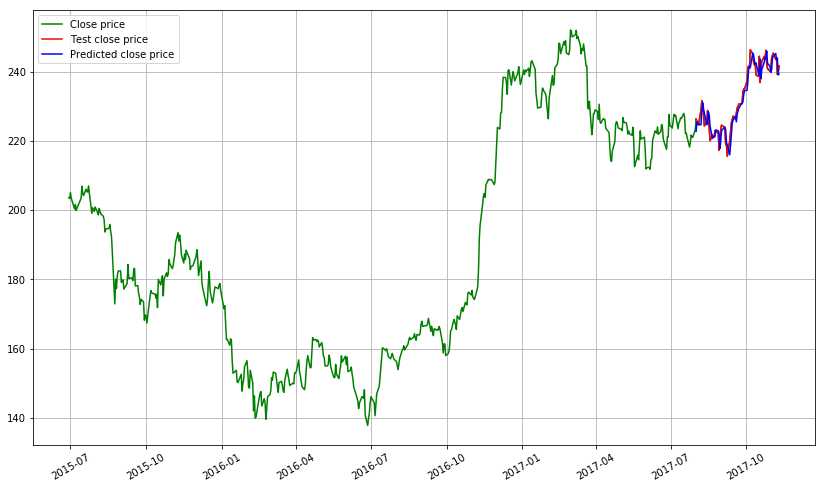

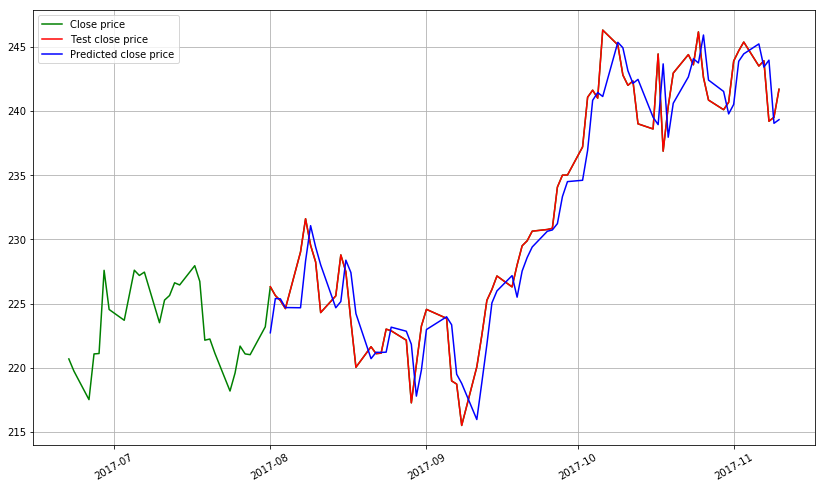

In [8]:
import warnings
warnings.filterwarnings('ignore')


train_ar = train_data['Open']
test_ar = test_data['Open']

model = AR(train_ar)# train autoregression
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train_ar[len(train_ar)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test_ar[t]
    predictions.append(yhat)
    history.append(obs)
 
plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label='Close price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Test close price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()

plt.figure(figsize=(14,8))
print('Lag: %s' % model_fit.k_ar)
plt.plot(data.index[-100:], data['Open'].tail(100), color='green', label='Close price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Test close price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()

print('MSE: '+str(mean_squared_error(test_data['Open'], predictions)))
print('MAE: '+str(mean_absolute_error(test_data['Open'], predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['Open'], predictions))))

# ARIMA

In [9]:
import math
train_arima = train_data['Open']
test_arima = test_data['Open']

history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

MSE: 6.626969094417472
MAE: 2.0120831475607113
RMSE: 2.57429001754221


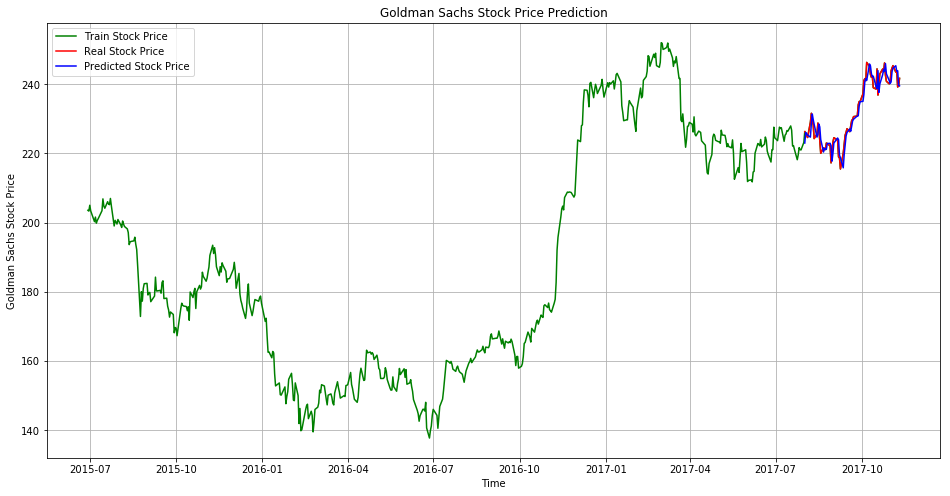

In [10]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Goldman Sachs Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Goldman Sachs Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()

# LSTM

In [11]:
train = train_data.iloc[:, 0:1].values # selecting open prices
# Feature Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 
# Train dataset
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from numpy.random import seed
seed(2019)

In [12]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
LSTM_model_ = model.fit(X_train, y_train, epochs = 10, batch_size = 16)

Epoch 1/10
4581/4581 [==============================] - 7s 2ms/step - loss: 0.0084
Epoch 2/10
4581/4581 [==============================] - 6s 1ms/step - loss: 0.0025
Epoch 3/10
4581/4581 [==============================] - 6s 1ms/step - loss: 0.0019
Epoch 4/10
4581/4581 [==============================] - 5s 1ms/step - loss: 0.0019
Epoch 5/10
4581/4581 [==============================] - 6s 1ms/step - loss: 0.0016
Epoch 6/10
4581/4581 [==============================] - 5s 1ms/step - loss: 0.0015
Epoch 7/10
4581/4581 [==============================] - 5s 1ms/step - loss: 0.0014
Epoch 8/10
4581/4581 [==============================] - 5s 1ms/step - loss: 0.0013
Epoch 9/10
4581/4581 [==============================] - 5s 1ms/step - loss: 0.0012
Epoch 10/10
4581/4581 [==============================] - 5s 1ms/step - loss: 0.0011


In [13]:
# this will be used later while comparing and visualization
real_stock_price = test_data.iloc[:,0:1].values # taking open price
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

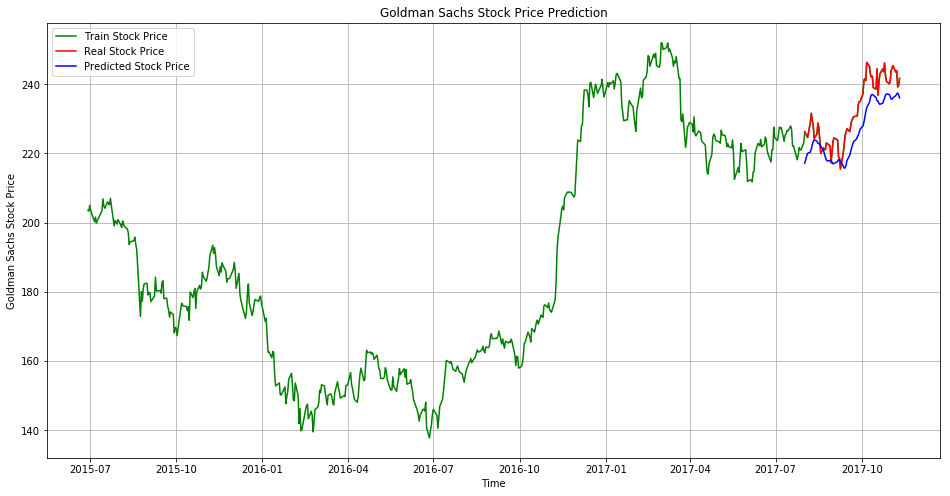

MSE: 46.0564421923173
MAE: 6.02459044574058
RMSE: 6.786489681147191


In [14]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Goldman Sachs Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Goldman Sachs Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

# LSTM Model 2

In [15]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 40, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))

model.add(LSTM(units = 40))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adamax', loss = 'mean_squared_error')

# Fitting the RNN to the Training set

model.fit(X_train, y_train, epochs = 10, batch_size = 80)

Epoch 1/10
4581/4581 [==============================] - 3s 552us/step - loss: 0.0225
Epoch 2/10
4581/4581 [==============================] - 2s 329us/step - loss: 0.0038
Epoch 3/10
4581/4581 [==============================] - 1s 305us/step - loss: 0.0032
Epoch 4/10
4581/4581 [==============================] - 2s 331us/step - loss: 0.0031
Epoch 5/10
4581/4581 [==============================] - 1s 306us/step - loss: 0.0030
Epoch 6/10
4581/4581 [==============================] - 1s 303us/step - loss: 0.0028
Epoch 7/10
4581/4581 [==============================] - 2s 344us/step - loss: 0.0028
Epoch 8/10
4581/4581 [==============================] - 1s 284us/step - loss: 0.0026
Epoch 9/10
4581/4581 [==============================] - 1s 287us/step - loss: 0.0025
Epoch 10/10
4581/4581 [==============================] - 1s 285us/step - loss: 0.0026


In [16]:
# this will be used later while comparing and visualization
real_stock_price = test_data.iloc[:,0:1].values # taking open price
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

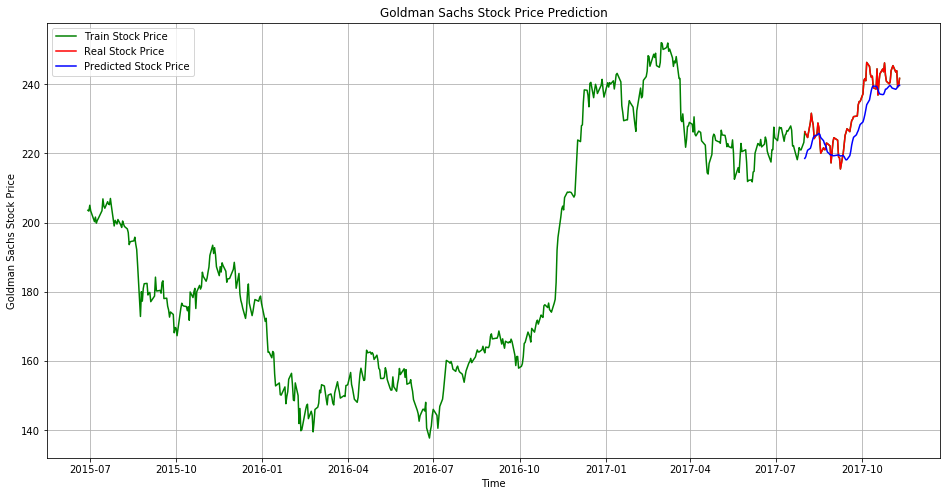

MSE: 30.133939463185072
MAE: 4.613752215659781
RMSE: 5.489438902400233


In [17]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Goldman Sachs Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Goldman Sachs Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

# LSTM model 3

In [18]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))

model.add(LSTM(units = 10))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adamax', loss = 'mean_squared_error')

# Fitting the RNN to the Training set

model.fit(X_train, y_train, epochs = 10, batch_size = 80)

Epoch 1/10
4581/4581 [==============================] - 3s 601us/step - loss: 0.0695
Epoch 2/10
4581/4581 [==============================] - 1s 239us/step - loss: 0.0192
Epoch 3/10
4581/4581 [==============================] - 1s 218us/step - loss: 0.0120
Epoch 4/10
4581/4581 [==============================] - 1s 218us/step - loss: 0.0106
Epoch 5/10
4581/4581 [==============================] - 1s 237us/step - loss: 0.0105
Epoch 6/10
4581/4581 [==============================] - 1s 241us/step - loss: 0.0099
Epoch 7/10
4581/4581 [==============================] - 1s 217us/step - loss: 0.0096
Epoch 8/10
4581/4581 [==============================] - 1s 200us/step - loss: 0.0088
Epoch 9/10
4581/4581 [==============================] - 1s 237us/step - loss: 0.0083
Epoch 10/10
4581/4581 [==============================] - 1s 224us/step - loss: 0.0081


In [19]:
# this will be used later while comparing and visualization
real_stock_price = test_data.iloc[:,0:1].values # taking open price
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

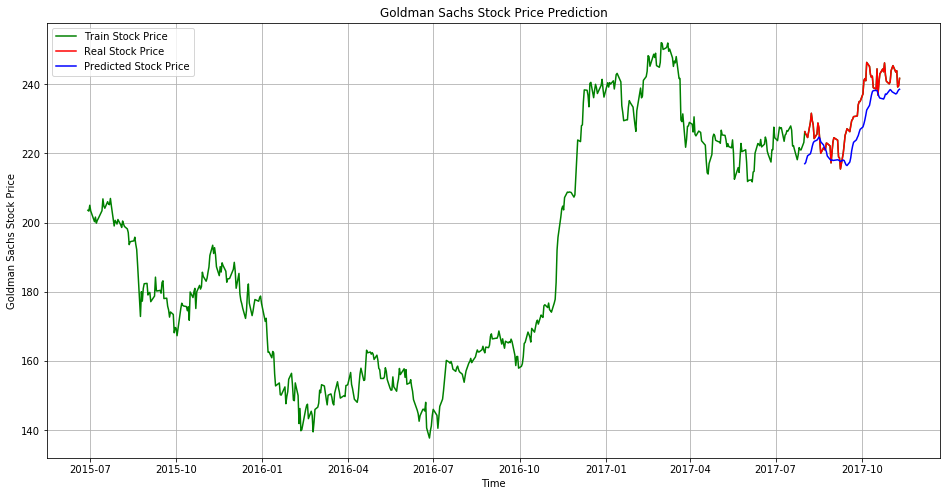

MSE: 43.68997711120724
MAE: 5.625604540681185
RMSE: 6.609839416446306


In [20]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Goldman Sachs Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Goldman Sachs Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

# LSTM Model 4

In [21]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 80, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))

model.add(LSTM(units = 80))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adamax', loss = 'mean_squared_error')

# Fitting the RNN to the Training set

model.fit(X_train, y_train, epochs = 10, batch_size = 150)

Epoch 1/10
4581/4581 [==============================] - 3s 748us/step - loss: 0.0258
Epoch 2/10
4581/4581 [==============================] - 2s 388us/step - loss: 0.0029
Epoch 3/10
4581/4581 [==============================] - 2s 373us/step - loss: 0.0021
Epoch 4/10
4581/4581 [==============================] - 2s 434us/step - loss: 0.0020 0s - loss: 0.
Epoch 5/10
4581/4581 [==============================] - 2s 396us/step - loss: 0.0020
Epoch 6/10
4581/4581 [==============================] - 2s 395us/step - loss: 0.0019
Epoch 7/10
4581/4581 [==============================] - 2s 391us/step - loss: 0.0019
Epoch 8/10
4581/4581 [==============================] - 2s 373us/step - loss: 0.0018
Epoch 9/10
4581/4581 [==============================] - 2s 390us/step - loss: 0.0018
Epoch 10/10
4581/4581 [==============================] - 2s 390us/step - loss: 0.0017


In [22]:
# this will be used later while comparing and visualization
real_stock_price = test_data.iloc[:,0:1].values # taking open price
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

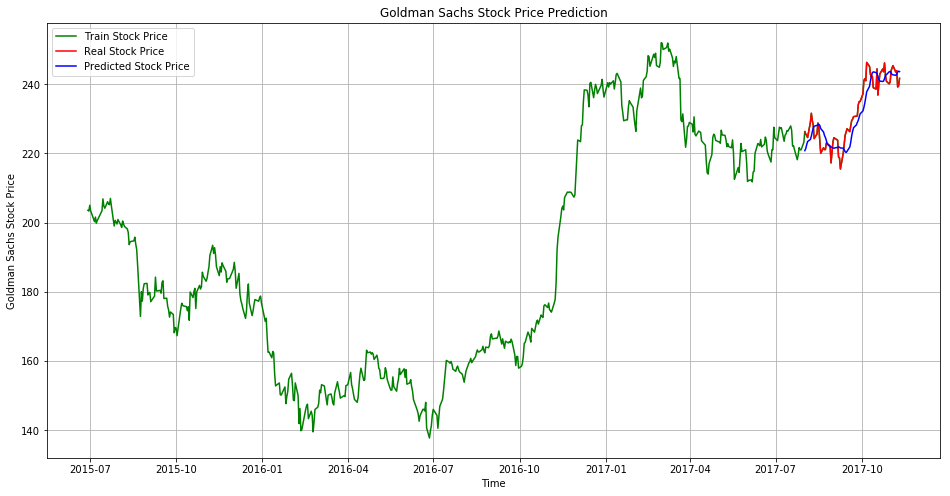

MSE: 14.920719170181297
MAE: 3.3192010581656683
RMSE: 3.8627346750950027


In [23]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Goldman Sachs Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Goldman Sachs Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

# LSTM Model 5 

In [24]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set

model.fit(X_train, y_train, epochs = 5, batch_size = 50)

Epoch 1/5
4581/4581 [==============================] - 5s 1ms/step - loss: 0.0137
Epoch 2/5
4581/4581 [==============================] - 3s 715us/step - loss: 0.0017
Epoch 3/5
4581/4581 [==============================] - 3s 719us/step - loss: 0.0016
Epoch 4/5
4581/4581 [==============================] - 3s 707us/step - loss: 0.0014
Epoch 5/5
4581/4581 [==============================] - 3s 716us/step - loss: 0.0014


In [25]:
# this will be used later while comparing and visualization
real_stock_price = test_data.iloc[:,0:1].values # taking open price
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

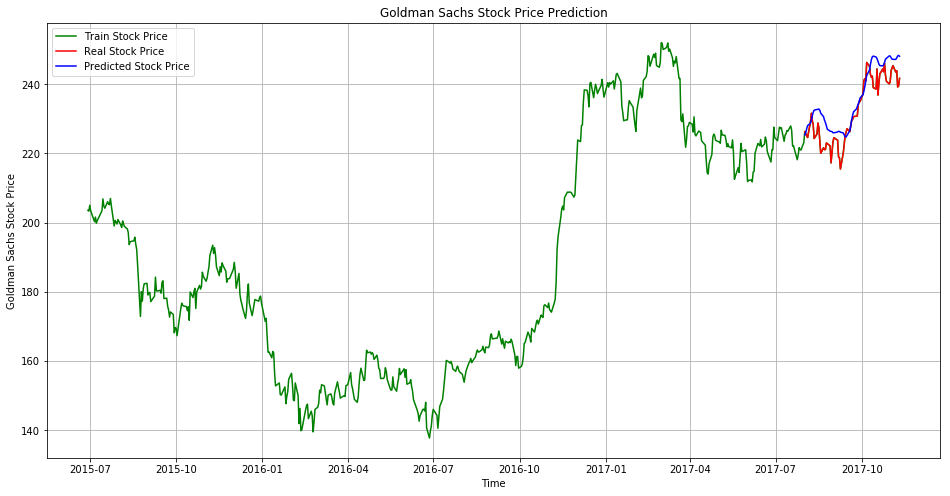

MSE: 26.831871566897544
MAE: 4.102454198549874
RMSE: 5.179948992692645


In [26]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Goldman Sachs Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Goldman Sachs Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))